In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests

In [2]:
# PARAMETERS
run_id="DMRs.07.23.ldcts"

In [3]:
# Parameters
run_id = "hypo_DMRs.07.24.ldcts"


In [4]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [5]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df.head()

/tmp/ipykernel_3108567/1445883874.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")


,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
0,SMC,5.051962e-08,2.328152e-08,0.015006,Wheeler.PlosMed.2017.HbA1c_,1.823749
1,Pericyte,1.826306e-08,1.136493e-08,0.054031,Wheeler.PlosMed.2017.HbA1c_,1.267358
2,VLMC,1.178275e-08,9.112311e-09,0.097995,Wheeler.PlosMed.2017.HbA1c_,1.008794
3,STR_Hybrid_MSN,8.252735e-09,1.147502e-08,0.236012,Wheeler.PlosMed.2017.HbA1c_,0.627067
4,Astrocyte,1.350631e-08,2.159231e-08,0.265817,Wheeler.PlosMed.2017.HbA1c_,0.575418


In [6]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [7]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [8]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

3534    0.245341
2977    0.245341
2976    0.245341
962     0.245341
961     0.245341
          ...   
1256    0.999964
1257    0.999964
1258    0.999964
1247    0.999964
3688    0.999964
Name: FDR_BH_corrected, Length: 3689, dtype: float64


In [9]:
print(adj_pval.sort_values())

2977    0.245341
2914    0.254370
1488    0.288717
2821    0.300054
3534    0.306298
          ...   
2904    1.156336
847     1.156392
3234    1.156392
948     1.156394
2371    1.156445
Name: adj_pval, Length: 3689, dtype: float64


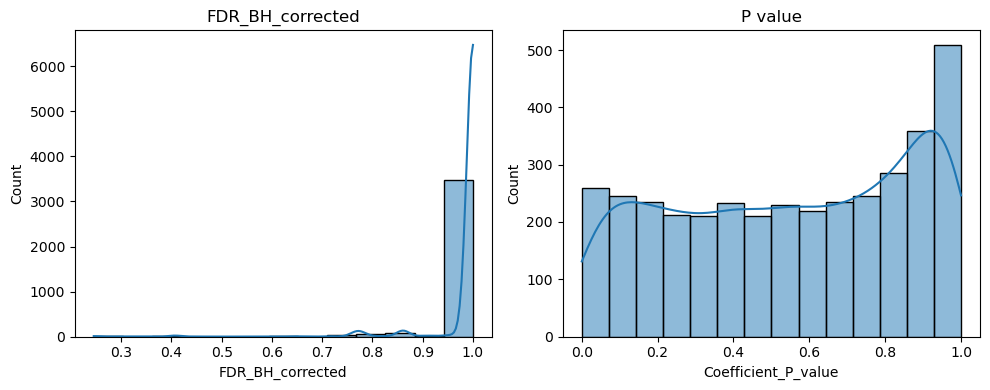

In [10]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [11]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Arvanitis.NatCommun.2019.Heart_Failure_,Astle.Cell.2016.Basophil_count_,Astle.Cell.2016.Eosinophil_count_,Astle.Cell.2016.Lymphocyte_count_,Astle.Cell.2016.Monocyte_count_,Astle.Cell.2016.Neutrophil_count_,Aylward.2018.biorxiv.Type_1_Diabetes_,Barban.NatGenet.2016.Age_First_Birth_,Barban.NatGenet.2016.Number_Children_Born_,Bentham.NatGenet.2015.Lupus_,...,Yengo.biorxiv.2018.BMI_,Yengo.biorxiv.2018.Height_,Zhu.RespirRes.2019.Hypertension_,deLange.NatGenet.2017.Crohns_Disease_,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,deLange.NatGenet.2017.Ulcerative_Colitis_,denHoed.NatGenet.2013.Heart_Rate_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_,vandenBerg.BehavGenet.2016.Extraversion_,vanderValk.HumMolGenet.2014.Birth_Length_
Name,,,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.111114,0.179473,0.041094,0.016388,0.043902,0.090011,0.156633,0.232824,0.220181,0.180301,...,0.325208,1.053921,0.033515,0.012826,0.011833,0.075107,0.207711,0.037805,0.352076,0.099299
Astrocyte,0.043469,0.047768,0.447988,0.514239,0.051854,0.289068,0.387139,0.494050,0.321429,0.217815,...,0.845431,0.920831,0.328159,0.368722,0.278291,0.017310,0.734417,0.195966,0.354824,0.163225
CN_Cholinergic_GABA,0.182052,0.266287,0.064178,1.153207,0.005178,0.660414,0.456160,0.414498,0.625494,0.180861,...,0.311489,0.088498,0.094389,0.199729,0.119539,0.097534,0.201717,0.086498,0.400327,0.332051
CN_GABA-Glut,0.000159,0.444015,0.122948,0.612430,0.077437,0.166222,0.093234,0.872583,0.617980,1.383644,...,1.043509,0.192615,0.051991,0.030822,0.000778,0.065247,0.226374,0.110119,0.207099,0.088375
CN_LAMP5-CXCL14_GABA,0.024862,0.052060,0.046275,0.091342,0.103029,0.037240,0.066135,0.212705,0.169773,0.147368,...,0.274818,0.263146,0.296230,0.030304,0.017258,0.099919,0.495547,0.096777,2.202394,0.634229


In [12]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Arvanitis.NatCommun.2019.Heart_Failure_,Astle.Cell.2016.Basophil_count_,Astle.Cell.2016.Eosinophil_count_,Astle.Cell.2016.Lymphocyte_count_,Astle.Cell.2016.Monocyte_count_,Astle.Cell.2016.Neutrophil_count_,Aylward.2018.biorxiv.Type_1_Diabetes_,Barban.NatGenet.2016.Age_First_Birth_,Barban.NatGenet.2016.Number_Children_Born_,Bentham.NatGenet.2015.Lupus_,...,Yengo.biorxiv.2018.BMI_,Yengo.biorxiv.2018.Height_,Zhu.RespirRes.2019.Hypertension_,deLange.NatGenet.2017.Crohns_Disease_,deLange.NatGenet.2017.Inflammatory_Bowel_Disease_,deLange.NatGenet.2017.Ulcerative_Colitis_,denHoed.NatGenet.2013.Heart_Rate_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_,vandenBerg.BehavGenet.2016.Extraversion_,vanderValk.HumMolGenet.2014.Birth_Length_
Name,,,,,,,,,,,,,,,,,,,,,
ACx_MEIS2_GABA,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,...,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964
Astrocyte,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,...,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964
CN_Cholinergic_GABA,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,...,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964
CN_GABA-Glut,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.860936,...,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964
CN_LAMP5-CXCL14_GABA,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,...,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.999964,0.761215,0.999964


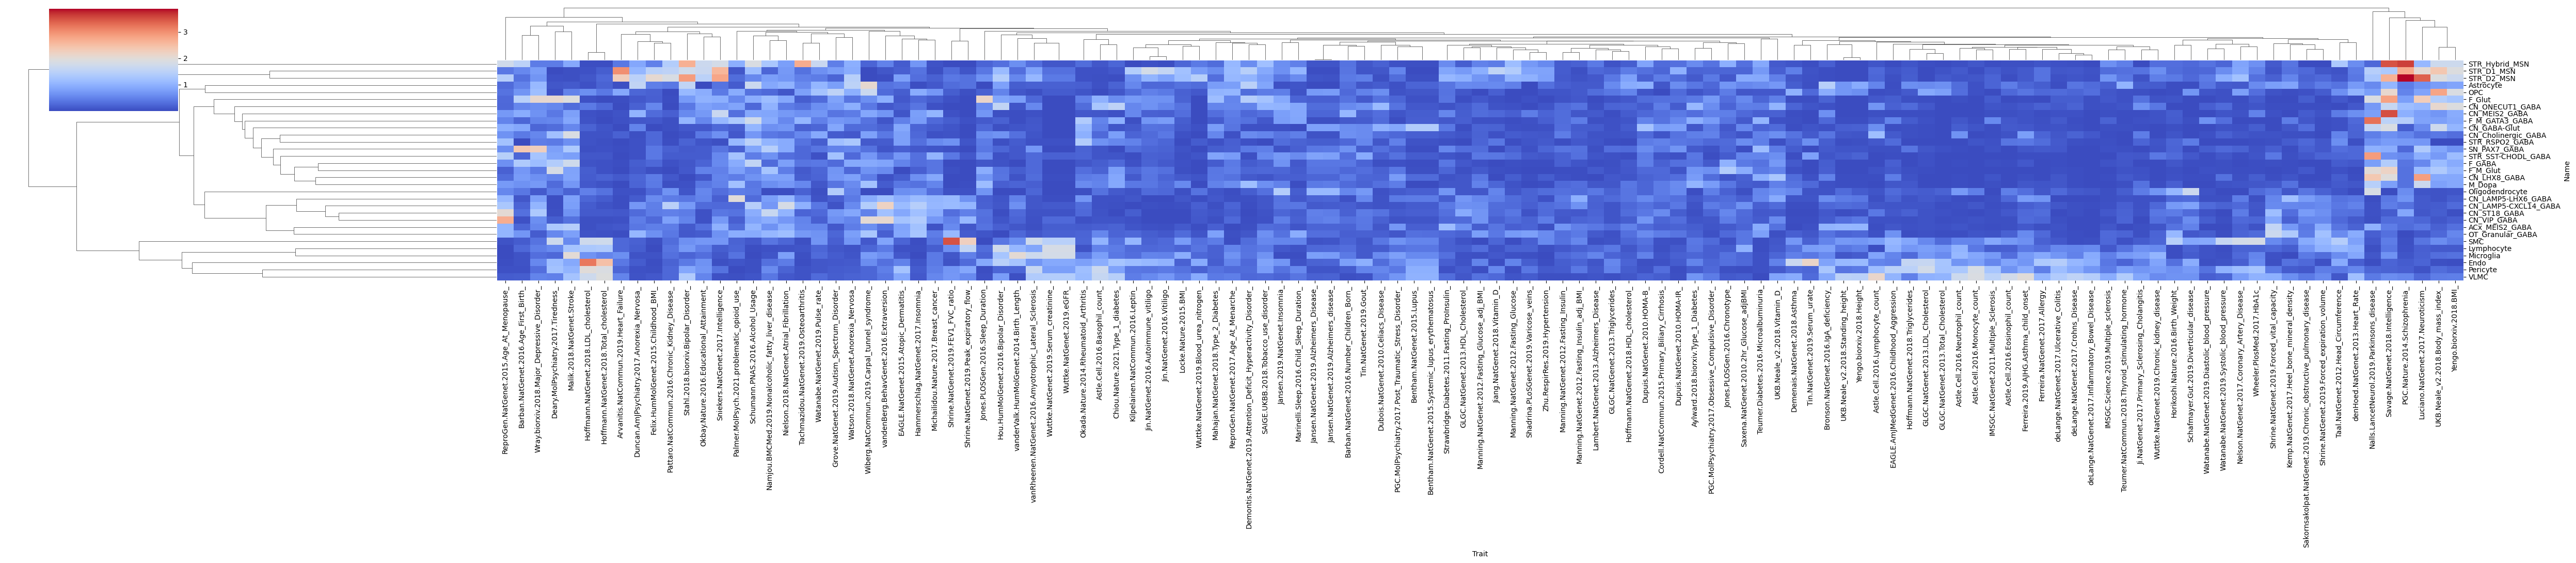

In [13]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(50, 11))

plt.show()
g.savefig(f'output/{run_id}.pdf')

In [14]:
def pval_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

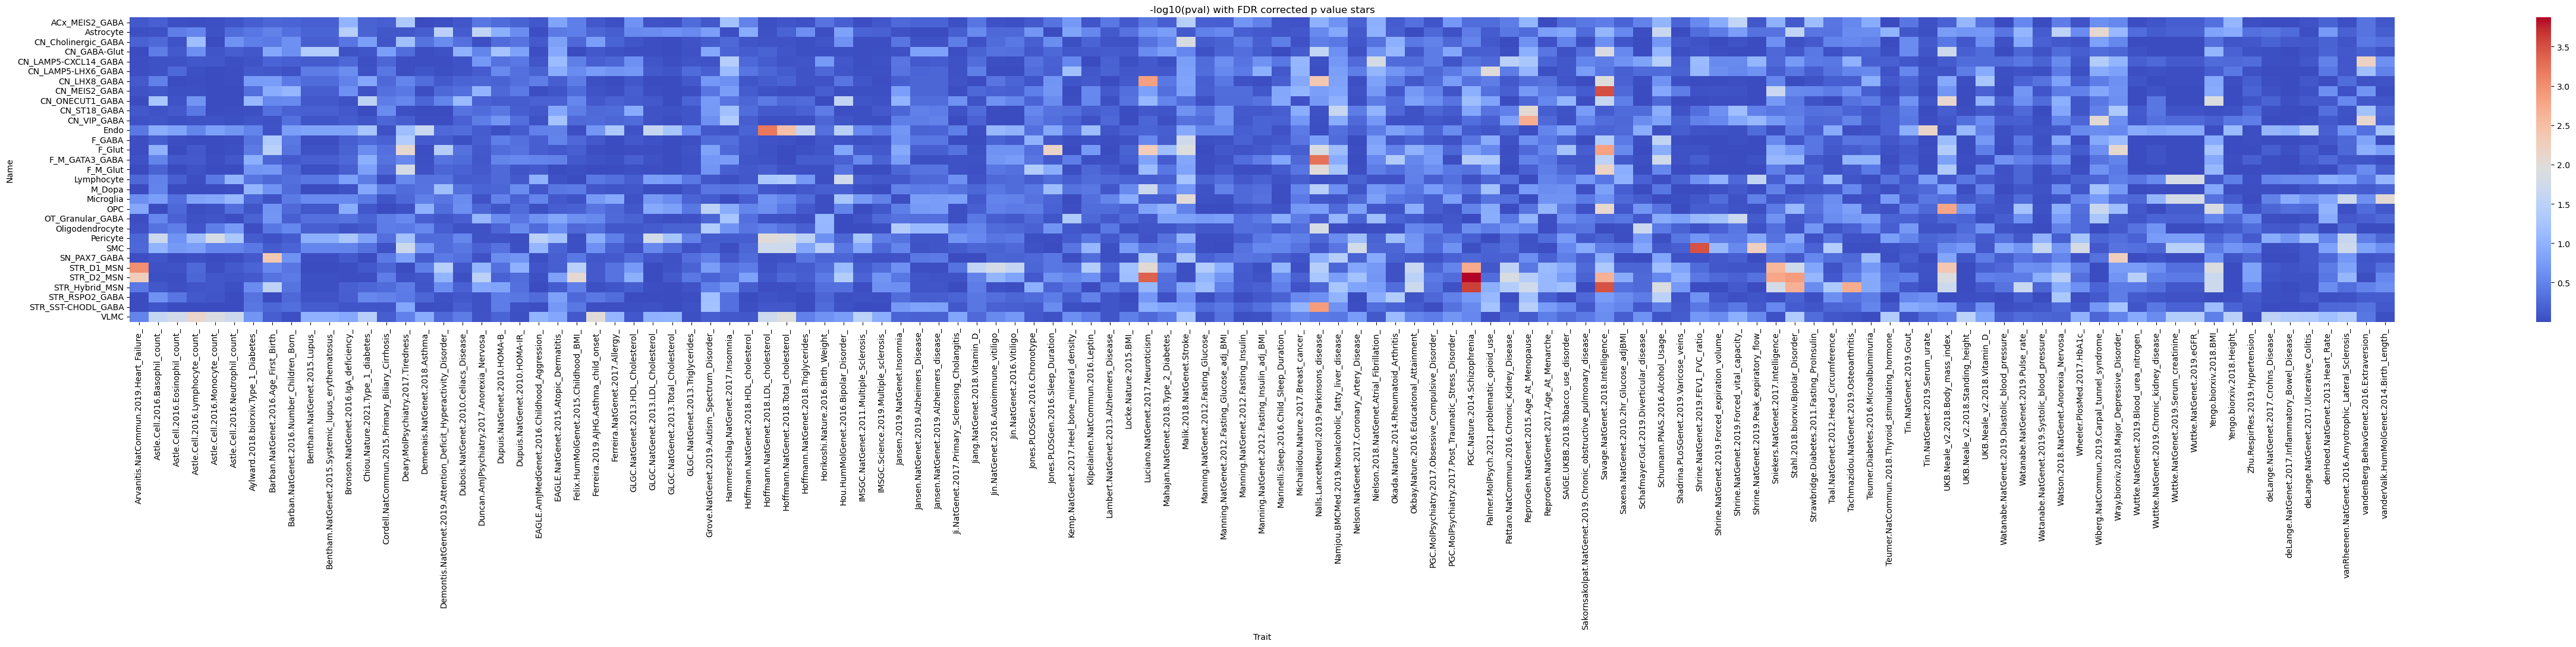

In [15]:
stars = fdr_modified_df.applymap(pval_to_star)

# Plot heatmap with annotations
plt.figure(figsize=(50, 11))
sns.heatmap(modified_df, annot=stars, fmt='', cmap='coolwarm')
plt.title("-log10(pval) with FDR corrected p value stars")
plt.tight_layout()
plt.savefig(f'output/{run_id}_FDR_corrected.pdf')
plt.show()

